In [1]:
import pandas as pd

df = pd.read_csv("inf_data_ee_mobilenet_1_branches_crescent_id_3_laptop_cifar10.csv")


,Unnamed: 0,device,target,class_name,conf_branch_1,correct_branch_1,delta_inf_time_branch_1,cum_inf_time_branch_1,prediction_branch_1,conf_branch_2,correct_branch_2,delta_inf_time_branch_2,cum_inf_time_branch_2,prediction_branch_2
0,0,cpu,3,cat,0.881393,1,0.029845,0.029845,3,0.937594,1,0.015497,0.045342,3
1,1,cpu,8,ship,0.965688,1,0.012400,0.012400,8,0.997032,1,0.008851,0.021251,8
2,2,cpu,8,ship,0.640382,1,0.012670,0.012670,8,0.817992,1,0.009214,0.021884,8
3,3,cpu,0,airplane,0.907204,0,0.013209,0.013209,8,0.481702,0,0.009187,0.022396,8
4,4,cpu,6,frog,0.970645,1,0.011823,0.011823,6,0.982622,1,0.008372,0.020195,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9995,cpu,8,ship,0.484242,0,0.014441,0.014441,0,0.731194,0,0.009469,0.023910,0
9996,9996,cpu,3,cat,0.601069,1,0.013813,0.013813,3,0.841194,1,0.009994,0.023807,3
9997,9997,cpu,5,dog,0.939522,1,0.013766,0.013766,5,0.990311,1,0.009367,0.023133,5
9998,9998,cpu,1,automobile,0.536349,1,0.013936,0.013936,1,0.976563,1,0.010207,0.024143,1


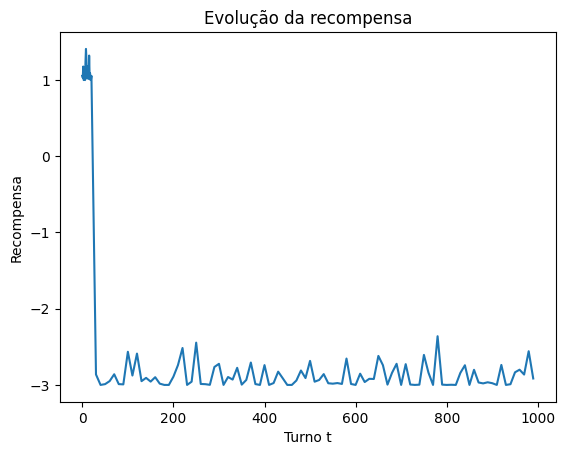

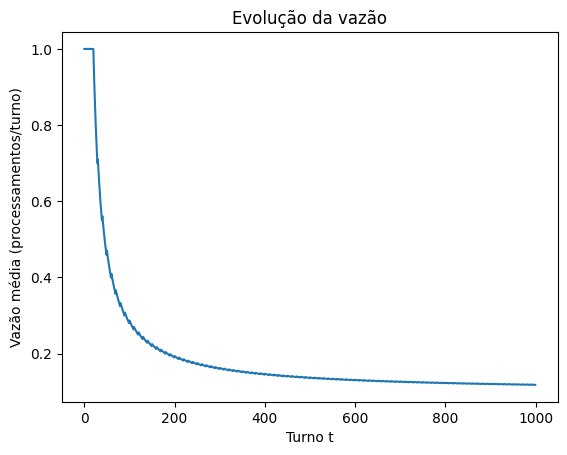

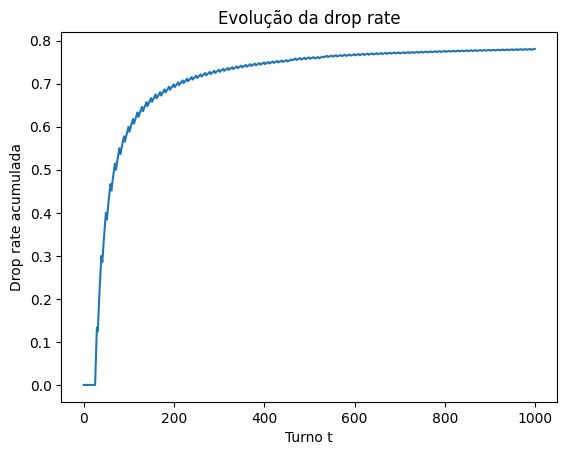

In [6]:
import numpy as np
import math
import matplotlib.pyplot as plt

# --- Parâmetros gerais ---
T = 1000                     # duração total (turnos)
lambda_rate = 5           # taxa de chegada
q_max = 5                   # capacidade do buffer
processing_time_dnn = 10    # ms por inferência DNN
n_arms = 20

theta1 = lambda t: 1
theta2 = lambda t: 1
alpha = lambda q, t: theta1(t)*q + theta2(t)

mu, kappa = 1, 1
offloading_cost = lambda q: mu*q - kappa

def reward_criteria(CI, CL, threshold, q):
    if CI < threshold:
        return max(CL - CI, 0) - offloading_cost(q)
    else:
        return 0

def poisson_process_arrivals(T, lambda_rate):
    p = 1 - np.exp(-lambda_rate)
    return np.random.binomial(1, p, T)

def select_arm(arms, t, avg_rewards, threshold, sample, q):
    ucb = []
    for i in range(len(arms)):
        exploit = reward_criteria(sample["conf_branch_1"],
                                  sample["conf_branch_2"],
                                  threshold, q)
        explore = math.sqrt(2 * math.log(max(t, 1)) / (arms[i] + 1))
        ucb.append(exploit + explore)
    return int(np.argmax(ucb))

# --- Preparação dos dados ---

samples = df.to_dict('records')
arrivals = poisson_process_arrivals(T, lambda_rate)

arms = [0]*n_arms
avg_rewards = [0.0]*n_arms

# --- Métricas a coletar ---
processed_flag = np.zeros(T, dtype=int)    # 1 se processou amostra em t
dropped_flag   = np.zeros(T, dtype=int)    # 1 se descartou amostra em t

# Para plotar recompensa vs turno
times, rewards = [], []

# --- Fase inicial: explorar cada braço 1 vez (sem atrasar a DNN) ---
for t0 in range(n_arms):
    s = samples.pop(0)
    thr = alpha(0, t0)
    a = select_arm(arms, t0, avg_rewards, thr, s, 0)
    r = reward_criteria(s["conf_branch_1"], s["conf_branch_2"], thr, 0)
    arms[a] += 1
    avg_rewards[a] += (r - avg_rewards[a]) / arms[a]
    # marca que foi processado
    processed_flag[t0] = 1
    times.append(t0)
    rewards.append(r)

# --- Loop principal ---
buffer = []
n_buf = 0
dnn_next_free_time = 0

for t in range(n_arms, T):
    is_dnn_free = (t >= dnn_next_free_time)

    if is_dnn_free:
        # se há na fila, processa primeiro
        if n_buf > 0:
            s = buffer.pop(0)
            n_buf -= 1
        # senão se chega nova amostra, processa direto
        elif arrivals[t] == 1 and samples:
            s = samples.pop(0)
        else:
            continue

        # atualização UCB e recompensa
        thr = alpha(n_buf, t)
        a = select_arm(arms, t, avg_rewards, thr, s, n_buf)
        r = reward_criteria(s["conf_branch_1"], s["conf_branch_2"], thr, n_buf)
        arms[a] += 1
        avg_rewards[a] += (r - avg_rewards[a]) / arms[a]

        # marca métricas de processamento
        processed_flag[t] = 1
        times.append(t)
        rewards.append(r)

        # DNN fica ocupada pelos próximos 10 ms
        dnn_next_free_time = t + processing_time_dnn

    else:
        # DNN ocupada: se chega nova amostra, tenta enfileirar
        if arrivals[t] == 1 and samples:
            s_new = samples.pop(0)
            if n_buf < q_max:
                buffer.append(s_new)
                n_buf += 1
            else:
                # buffer cheio → descarta
                dropped_flag[t] = 1

# --- Cálculo de Vazão e Drop Rate acumuladas ---
cum_processed = np.cumsum(processed_flag)
cum_arrivals  = np.cumsum(arrivals)
cum_dropped   = np.cumsum(dropped_flag)

# vazão média até t: amostras processadas / t
throughput = cum_processed / np.arange(1, T+1)

# drop rate acumulada até t: descartes / chegadas (evita div/0)
drop_rate = np.zeros(T)
nonzero = cum_arrivals > 0
drop_rate[nonzero] = cum_dropped[nonzero] / cum_arrivals[nonzero]

# --- Plot: recompensa vs turno (exemplo) ---
plt.figure()
plt.plot(times, rewards)
plt.xlabel('Turno t')
plt.ylabel('Recompensa')
plt.title('Evolução da recompensa')

# --- Plot: vazão vs turno ---
plt.figure()
plt.plot(np.arange(T), throughput)
plt.xlabel('Turno t')
plt.ylabel('Vazão média (processamentos/turno)')
plt.title('Evolução da vazão')

# --- Plot: drop rate vs turno ---
plt.figure()
plt.plot(np.arange(T), drop_rate)
plt.xlabel('Turno t')
plt.ylabel('Drop rate acumulada')
plt.title('Evolução da drop rate')

plt.show()
